# Mutation analysis in AY.27

In [1]:
import pandas as pd
import genomics_data_index.api as gdi
import genomics_data_index

print(genomics_data_index.__version__)
db = gdi.GenomicsDataIndex.connect('index')
db

0.4.0.dev1


<GenomicsDataIndex(samples=8011)>

In [2]:
db.reference_names()

['NC_045512']

# Load metadata

In [3]:
metadata_df = pd.read_csv('input/twentysevenext_subsampled_metadata.tsv.gz', sep='\t')
metadata_df['is_canada'] = metadata_df['country'] == 'Canada'
metadata_df['pango_lineage_location'] = metadata_df['pango_lineage'] + '_Not_Canada'
metadata_df.loc[metadata_df['is_canada'], 'pango_lineage_location'] = metadata_df['pango_lineage'] + '_Canada'
metadata_df['date'] = metadata_df['date'].astype('datetime64')
metadata_df['strain'].head(3)

0    Australia/VIC18777/2021
1     Bahrain/920845243/2021
2    Australia/VIC18721/2021
Name: strain, dtype: object

In [4]:
metadata_df[metadata_df['pango_lineage'] == 'AY.27']['country'].value_counts()

Canada            7522
USA                192
India               97
Denmark             23
United Kingdom      21
Germany             13
Netherlands          6
Lithuania            5
South Korea          5
Switzerland          3
Spain                3
Bahrain              2
Turkey               2
Sweden               2
Kenya                2
Georgia              2
Bulgaria             2
Belgium              2
Aruba                1
Kuwait               1
Ireland              1
Norway               1
Romania              1
Philippines          1
Hong Kong            1
Slovenia             1
France               1
Croatia              1
Zambia               1
Name: country, dtype: int64

In [5]:
metadata_df['pango_lineage_location'].value_counts().head(5)

AY.27_Canada            7522
AY.27_Not_Canada         393
B.1.1.7_Not_Canada        12
B.1_Not_Canada            12
B.1.617.2_Not_Canada      10
Name: pango_lineage_location, dtype: int64

In [6]:
metadata_df['is_canada'].value_counts()

True     7524
False     488
Name: is_canada, dtype: int64

In [7]:
metadata_df[metadata_df['pango_lineage'] == 'AY.27']['is_canada'].value_counts()

True     7522
False     393
Name: is_canada, dtype: int64

In [8]:
metadata_df.columns

Index(['strain', 'gisaid_epi_isl', 'date', 'region', 'country', 'division',
       'pango_lineage', 'purpose_of_sequencing', 'region_exposure',
       'country_exposure', 'division_exposure', 'virus', 'genbank_accession',
       'location', 'segment', 'length', 'host', 'age', 'sex', 'GISAID_clade',
       'originating_lab', 'submitting_lab', 'authors', 'url', 'title',
       'paper_url', 'date_submitted', 'sampling_strategy', 'can', 'worldwide',
       'is_canada', 'pango_lineage_location'],
      dtype='object')

# Load tree

## Time tree

In [9]:
from ete3 import Tree

reference_name = 'Wuhan/Hu-1/2019' # Confirmed this is identical to NC_045512
delta_tree = Tree('tree.nwk', format=1)
delta_tree.get_leaf_names()[0:5]

['Wuhan/Hu-1/2019',
 'Wuhan/WH01/2019',
 'PapuaNewGuinea/35/2020',
 'Iran/GRC-2287/2020',
 'Suriname/SR-137/2021']

# Load reference

In [10]:
from Bio import SeqIO
import gzip

with gzip.open('../references/NC_045512.gbk.gz', 'rt') as fh:
    records = list(SeqIO.parse(fh, 'genbank'))

record = records[0]
reference_length = len(record.seq)
print(f'{record.id} is {reference_length} bp')

NC_045512.2 is 29903 bp


# Join to metadata and delta tree

## Time tree

In [11]:
q = db.samples_query(reference_name='NC_045512', universe='mutations')
q

<SamplesQueryIndex[selected=100% (8011/8011) samples, unknown=0% (0/8011) samples]>

In [12]:
t = q.join_tree(delta_tree, alignment_length=reference_length, kind='mutation', reference_name=reference_name)\
     .join(metadata_df, sample_names_column='strain').reset_universe()
t = t.set_outgroup(reference_name)
t

Passed tree has 8011 leaves, but only 8012 match samples in the system. Pruning tree to match samples in system.


<MutationTreeSamplesQuery[selected=100% (8011/8011) samples, unknown=0% (0/8011) samples]>

# All of AY.27

In [13]:
t27 = t.isa(r'^AY.27', regex=True, isa_column='pango_lineage', kind='dataframe')
t27

<MutationTreeSamplesQuery[selected=99% (7915/8011) samples, unknown=0% (0/8011) samples]>

In [14]:
t27_features_df = t27.features_summary().sort_values('Count', ascending=False)
t27_features_df

,Sequence,Position,Deletion,Insertion,Type,Count,Total,Percent,Annotation,Annotation_Impact,Gene_Name,Gene_ID,Feature_Type,Transcript_BioType,HGVS.c,HGVS.p,ID_HGVS.c,ID_HGVS.p,ID_HGVS_GN.c,ID_HGVS_GN.p
Mutation,,,,,,,,,,,,,,,,,,,,
NC_045512.2:25469:C:T,NC_045512.2,25469,C,T,SNP,7915,7915,100.000000,missense_variant,MODERATE,ORF3a,GU280_gp03,transcript,protein_coding,c.77C>T,p.S26L,hgvs:NC_045512.2:GU280_gp03:c.77C>T,hgvs:NC_045512.2:GU280_gp03:p.S26L,hgvs_gn:NC_045512.2:ORF3a:c.77C>T,hgvs_gn:NC_045512.2:ORF3a:p.S26L
NC_045512.2:26767:T:C,NC_045512.2,26767,T,C,SNP,7915,7915,100.000000,missense_variant,MODERATE,M,GU280_gp05,transcript,protein_coding,c.245T>C,p.I82T,hgvs:NC_045512.2:GU280_gp05:c.245T>C,hgvs:NC_045512.2:GU280_gp05:p.I82T,hgvs_gn:NC_045512.2:M:c.245T>C,hgvs_gn:NC_045512.2:M:p.I82T
NC_045512.2:28881:G:T,NC_045512.2,28881,G,T,SNP,7915,7915,100.000000,missense_variant,MODERATE,N,GU280_gp10,transcript,protein_coding,c.608G>T,p.R203M,hgvs:NC_045512.2:GU280_gp10:c.608G>T,hgvs:NC_045512.2:GU280_gp10:p.R203M,hgvs_gn:NC_045512.2:N:c.608G>T,hgvs_gn:NC_045512.2:N:p.R203M
NC_045512.2:14408:C:T,NC_045512.2,14408,C,T,SNP,7913,7915,99.974732,missense_variant,MODERATE,ORF1ab,GU280_gp01,transcript,protein_coding,c.14144C>T,p.P4715L,hgvs:NC_045512.2:GU280_gp01:c.14144C>T,hgvs:NC_045512.2:GU280_gp01:p.P4715L,hgvs_gn:NC_045512.2:ORF1ab:c.14144C>T,hgvs_gn:NC_045512.2:ORF1ab:p.P4715L
NC_045512.2:15451:G:A,NC_045512.2,15451,G,A,SNP,7911,7915,99.949463,missense_variant,MODERATE,ORF1ab,GU280_gp01,transcript,protein_coding,c.15187G>A,p.G5063S,hgvs:NC_045512.2:GU280_gp01:c.15187G>A,hgvs:NC_045512.2:GU280_gp01:p.G5063S,hgvs_gn:NC_045512.2:ORF1ab:c.15187G>A,hgvs_gn:NC_045512.2:ORF1ab:p.G5063S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC_045512.2:18703:G:T,NC_045512.2,18703,G,T,SNP,1,7915,0.012634,missense_variant,MODERATE,ORF1ab,GU280_gp01,transcript,protein_coding,c.18439G>T,p.D6147Y,hgvs:NC_045512.2:GU280_gp01:c.18439G>T,hgvs:NC_045512.2:GU280_gp01:p.D6147Y,hgvs_gn:NC_045512.2:ORF1ab:c.18439G>T,hgvs_gn:NC_045512.2:ORF1ab:p.D6147Y
NC_045512.2:28055:A:G,NC_045512.2,28055,A,G,SNP,1,7915,0.012634,synonymous_variant,LOW,ORF8,GU280_gp09,transcript,protein_coding,c.162A>G,p.S54S,hgvs:NC_045512.2:GU280_gp09:c.162A>G,hgvs:NC_045512.2:GU280_gp09:p.S54S,hgvs_gn:NC_045512.2:ORF8:c.162A>G,hgvs_gn:NC_045512.2:ORF8:p.S54S
NC_045512.2:21191:C:T,NC_045512.2,21191,C,T,SNP,1,7915,0.012634,missense_variant,MODERATE,ORF1ab,GU280_gp01,transcript,protein_coding,c.20927C>T,p.A6976V,hgvs:NC_045512.2:GU280_gp01:c.20927C>T,hgvs:NC_045512.2:GU280_gp01:p.A6976V,hgvs_gn:NC_045512.2:ORF1ab:c.20927C>T,hgvs_gn:NC_045512.2:ORF1ab:p.A6976V


# Unique to AY.27

In [15]:
t27.features_summary(selection='unique').sort_values('Count', ascending=False).head(5)

,Sequence,Position,Deletion,Insertion,Type,Count,Total,Percent,Annotation,Annotation_Impact,Gene_Name,Gene_ID,Feature_Type,Transcript_BioType,HGVS.c,HGVS.p,ID_HGVS.c,ID_HGVS.p,ID_HGVS_GN.c,ID_HGVS_GN.p
Mutation,,,,,,,,,,,,,,,,,,,,
NC_045512.2:11938:T:C,NC_045512.2,11938,T,C,SNP,7781,7915,98.307012,synonymous_variant,LOW,ORF1ab,GU280_gp01,transcript,protein_coding,c.11673T>C,p.C3891C,hgvs:NC_045512.2:GU280_gp01:c.11673T>C,hgvs:NC_045512.2:GU280_gp01:p.C3891C,hgvs_gn:NC_045512.2:ORF1ab:c.11673T>C,hgvs_gn:NC_045512.2:ORF1ab:p.C3891C
NC_045512.2:14475:A:G,NC_045512.2,14475,A,G,SNP,7630,7915,96.399242,synonymous_variant,LOW,ORF1ab,GU280_gp01,transcript,protein_coding,c.1035A>G,p.G345G,hgvs:NC_045512.2:GU280_gp01:c.1035A>G,hgvs:NC_045512.2:GU280_gp01:p.G345G,hgvs_gn:NC_045512.2:ORF1ab:c.1035A>G,hgvs_gn:NC_045512.2:ORF1ab:p.G345G
NC_045512.2:26763:G:T,NC_045512.2,26763,G,T,SNP,7339,7915,92.722678,missense_variant,MODERATE,M,GU280_gp05,transcript,protein_coding,c.241G>T,p.A81S,hgvs:NC_045512.2:GU280_gp05:c.241G>T,hgvs:NC_045512.2:GU280_gp05:p.A81S,hgvs_gn:NC_045512.2:M:c.241G>T,hgvs_gn:NC_045512.2:M:p.A81S
NC_045512.2:16338:C:T,NC_045512.2,16338,C,T,SNP,7235,7915,91.408718,synonymous_variant,LOW,ORF1ab,GU280_gp01,transcript,protein_coding,c.102C>T,p.V34V,hgvs:NC_045512.2:GU280_gp01:c.102C>T,hgvs:NC_045512.2:GU280_gp01:p.V34V,hgvs_gn:NC_045512.2:ORF1ab:c.102C>T,hgvs_gn:NC_045512.2:ORF1ab:p.V34V
NC_045512.2:29507:A:C,NC_045512.2,29507,A,C,SNP,7051,7915,89.084018,missense_variant,MODERATE,N,GU280_gp10,transcript,protein_coding,c.1234A>C,p.S412R,hgvs:NC_045512.2:GU280_gp10:c.1234A>C,hgvs:NC_045512.2:GU280_gp10:p.S412R,hgvs_gn:NC_045512.2:N:c.1234A>C,hgvs_gn:NC_045512.2:N:p.S412R


# In some but not all AY.27

In [16]:
percent_thresholds = [10, 90]

t27_features_noid_all_df = t27.features_summary().sort_values('Count', ascending=False)
t27_features_noid_df = t27_features_noid_all_df[(t27_features_noid_all_df['Percent'] > percent_thresholds[0]) & (t27_features_noid_all_df['Percent'] < percent_thresholds[1])]

t27_features_noid_df

,Sequence,Position,Deletion,Insertion,Type,Count,Total,Percent,Annotation,Annotation_Impact,Gene_Name,Gene_ID,Feature_Type,Transcript_BioType,HGVS.c,HGVS.p,ID_HGVS.c,ID_HGVS.p,ID_HGVS_GN.c,ID_HGVS_GN.p
Mutation,,,,,,,,,,,,,,,,,,,,
NC_045512.2:29507:A:C,NC_045512.2,29507,A,C,SNP,7051,7915,89.084018,missense_variant,MODERATE,N,GU280_gp10,transcript,protein_coding,c.1234A>C,p.S412R,hgvs:NC_045512.2:GU280_gp10:c.1234A>C,hgvs:NC_045512.2:GU280_gp10:p.S412R,hgvs_gn:NC_045512.2:N:c.1234A>C,hgvs_gn:NC_045512.2:N:p.S412R
NC_045512.2:23401:G:T,NC_045512.2,23401,G,T,SNP,5719,7915,72.255212,missense_variant,MODERATE,S,GU280_gp02,transcript,protein_coding,c.1839G>T,p.Q613H,hgvs:NC_045512.2:GU280_gp02:c.1839G>T,hgvs:NC_045512.2:GU280_gp02:p.Q613H,hgvs_gn:NC_045512.2:S:c.1839G>T,hgvs_gn:NC_045512.2:S:p.Q613H
NC_045512.2:4913:G:T,NC_045512.2,4913,G,T,SNP,919,7915,11.610865,missense_variant,MODERATE,ORF1ab,GU280_gp01,transcript,protein_coding,c.2194G>T,p.V732F,hgvs:NC_045512.2:GU280_gp01:c.2194G>T,hgvs:NC_045512.2:GU280_gp01:p.V732F,hgvs_gn:NC_045512.2:ORF1ab:c.2194G>T,hgvs_gn:NC_045512.2:ORF1ab:p.V732F
NC_045512.2:2325:C:T,NC_045512.2,2325,C,T,SNP,919,7915,11.610865,missense_variant,MODERATE,ORF1ab,GU280_gp01,transcript,protein_coding,c.1520C>T,p.A507V,hgvs:NC_045512.2:GU280_gp01:c.1520C>T,hgvs:NC_045512.2:GU280_gp01:p.A507V,hgvs_gn:NC_045512.2:ORF1ab:c.1520C>T,hgvs_gn:NC_045512.2:ORF1ab:p.A507V


In [17]:
def setup_id(df: pd.DataFrame, hgvs_p_col: str) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy['HGVS.p'] = df_copy['HGVS.p'].fillna('<NA>')
    df_copy['ID'] = df_copy['Gene_Name'] + ':' \
      + df_copy['HGVS.p'].str.replace(r'^p.','', regex=True) \
      + '_(g.' + df_copy['Position'].astype(str) + df_copy['Deletion'] + '>' + df_copy['Insertion'] + ')'
    df_copy['SPDI'] = df_copy.index
    
    return df_copy

def setup_and_fix_ids(features_df: pd.DataFrame) -> pd.DataFrame:
    """
    Fixes HGVS.p identifiers to correspond to proper location (mainly beginning of ORF1ab)
    Each of these was verified as being the proper name by examining the VCF and Genbank files
    """    
    features_df_copy = features_df.copy()
    
    features_df_copy.loc[
        features_df_copy['ID_HGVS_GN.p'] == 'hgvs_gn:NC_045512.2:ORF1ab:p.D410G', 'HGVS.p'] = 'p.D1228G'
    features_df_copy.loc[
        features_df_copy['ID_HGVS_GN.p'] == 'hgvs_gn:NC_045512.2:ORF1ab:p.E587K', 'HGVS.p'] = 'p.E767K'
    
    features_df_copy.loc[
        features_df_copy['ID_HGVS_GN.p'] == 'hgvs_gn:NC_045512.2:ORF1ab:p.A507V', 'HGVS.p'] = 'p.A687V'
    features_df_copy.loc[
        features_df_copy['ID_HGVS_GN.p'] == 'hgvs_gn:NC_045512.2:ORF1ab:p.V732F', 'HGVS.p'] = 'p.V1550F'
    
    features_df_copy = setup_id(features_df_copy, hgvs_p_col='HGVS.p')
    
    return features_df_copy

t27_features_df = setup_and_fix_ids(t27_features_noid_df)
t27_features_df

,Sequence,Position,Deletion,Insertion,Type,Count,Total,Percent,Annotation,Annotation_Impact,...,Feature_Type,Transcript_BioType,HGVS.c,HGVS.p,ID_HGVS.c,ID_HGVS.p,ID_HGVS_GN.c,ID_HGVS_GN.p,ID,SPDI
Mutation,,,,,,,,,,,,,,,,,,,,,
NC_045512.2:29507:A:C,NC_045512.2,29507,A,C,SNP,7051,7915,89.084018,missense_variant,MODERATE,...,transcript,protein_coding,c.1234A>C,p.S412R,hgvs:NC_045512.2:GU280_gp10:c.1234A>C,hgvs:NC_045512.2:GU280_gp10:p.S412R,hgvs_gn:NC_045512.2:N:c.1234A>C,hgvs_gn:NC_045512.2:N:p.S412R,N:S412R_(g.29507A>C),NC_045512.2:29507:A:C
NC_045512.2:23401:G:T,NC_045512.2,23401,G,T,SNP,5719,7915,72.255212,missense_variant,MODERATE,...,transcript,protein_coding,c.1839G>T,p.Q613H,hgvs:NC_045512.2:GU280_gp02:c.1839G>T,hgvs:NC_045512.2:GU280_gp02:p.Q613H,hgvs_gn:NC_045512.2:S:c.1839G>T,hgvs_gn:NC_045512.2:S:p.Q613H,S:Q613H_(g.23401G>T),NC_045512.2:23401:G:T
NC_045512.2:4913:G:T,NC_045512.2,4913,G,T,SNP,919,7915,11.610865,missense_variant,MODERATE,...,transcript,protein_coding,c.2194G>T,p.V1550F,hgvs:NC_045512.2:GU280_gp01:c.2194G>T,hgvs:NC_045512.2:GU280_gp01:p.V732F,hgvs_gn:NC_045512.2:ORF1ab:c.2194G>T,hgvs_gn:NC_045512.2:ORF1ab:p.V732F,ORF1ab:V1550F_(g.4913G>T),NC_045512.2:4913:G:T
NC_045512.2:2325:C:T,NC_045512.2,2325,C,T,SNP,919,7915,11.610865,missense_variant,MODERATE,...,transcript,protein_coding,c.1520C>T,p.A687V,hgvs:NC_045512.2:GU280_gp01:c.1520C>T,hgvs:NC_045512.2:GU280_gp01:p.A507V,hgvs_gn:NC_045512.2:ORF1ab:c.1520C>T,hgvs_gn:NC_045512.2:ORF1ab:p.A507V,ORF1ab:A687V_(g.2325C>T),NC_045512.2:2325:C:T


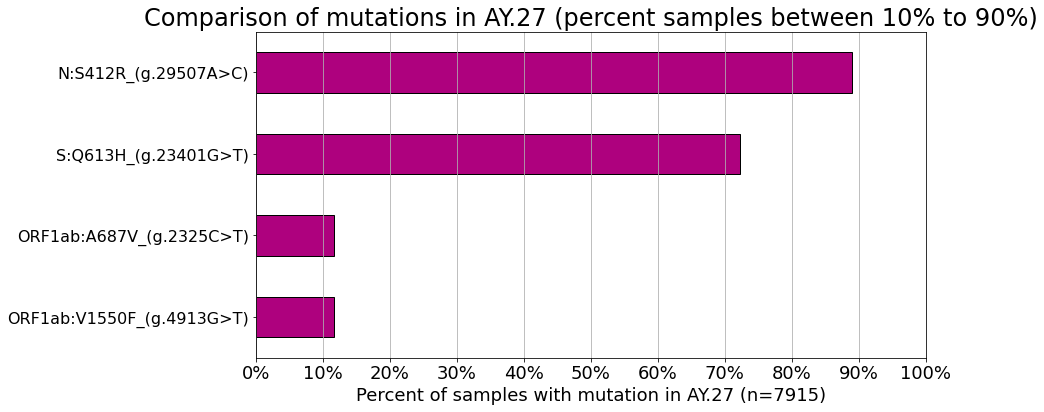

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

ax = t27_features_df.set_index('ID')['Percent'].sort_values(ascending=True).plot(
    kind='barh', figsize=(12,6), edgecolor='black', color=['#ae017e'])

plt.title(f'Comparison of mutations in AY.27 (percent samples between {percent_thresholds[0]}% to {percent_thresholds[1]}%)',
          fontdict={'size': 24})
plt.xlabel(f'Percent of samples with mutation in AY.27 (n={len(t27)})', fontdict={'size': 18})
plt.xticks(range(0, 100 + 1, 10), fontsize=18)
plt.ylabel('')
plt.yticks(fontsize=16)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(100))
plt.grid(axis='x')

In [19]:
ay27_mutations_percent_dict = t27_features_df.reset_index().set_index('Mutation')['ID'].to_dict()
ay27_mutations_percent_dict

{'NC_045512.2:29507:A:C': 'N:S412R_(g.29507A>C)',
 'NC_045512.2:23401:G:T': 'S:Q613H_(g.23401G>T)',
 'NC_045512.2:4913:G:T': 'ORF1ab:V1550F_(g.4913G>T)',
 'NC_045512.2:2325:C:T': 'ORF1ab:A687V_(g.2325C>T)'}

In [20]:
ay27_mutations_percent_list = t27_features_df.reset_index()['Mutation'].tolist()
ay27_mutations_percent_list
ay27_mutations_percent_list

['NC_045512.2:29507:A:C',
 'NC_045512.2:23401:G:T',
 'NC_045512.2:4913:G:T',
 'NC_045512.2:2325:C:T']

In [21]:
c1 = ['#ae017e', '#f768a1']
c2 = ['#238443', '#78c679']

colors = c1 + c2
ay27_mutations_colors = {m: c for m, c in zip(ay27_mutations_percent_list, colors)}
ay27_mutations_colors

{'NC_045512.2:29507:A:C': '#ae017e',
 'NC_045512.2:23401:G:T': '#f768a1',
 'NC_045512.2:4913:G:T': '#238443',
 'NC_045512.2:2325:C:T': '#78c679'}

# Tree

## Top provinces

In [22]:
t27_canada = t.isa('AY.27', isa_column='pango_lineage', kind='dataframe')\
              .isa('Canada', isa_column='country', kind='dataframe')\
              .reset_universe()
t27_canada

<MutationTreeSamplesQuery[selected=100% (7522/7522) samples, unknown=0% (0/7522) samples]>

In [23]:
t27_non_canadian = (t.isa('AY.27', isa_column='pango_lineage', kind='dataframe') &
                   ~t.isa('Canada', isa_column='country', kind='dataframe'))
t27_non_canadian

<MutationTreeSamplesQuery[selected=5% (393/8011) samples, unknown=0% (0/8011) samples]>

In [24]:
top_n = 3

t27_canada_df = t27_canada.toframe()
top_provinces = t27_canada_df['division'].value_counts()
print(top_provinces)
top_provinces = t27_canada_df['division'].value_counts().iloc[0:top_n].index.tolist()

t_provinces = {p.replace(' ', '_'): t27_canada.isa(p, isa_column='division', kind='dataframe') for p in top_provinces}
top_provinces = [p.replace(' ', '_') for p in top_provinces]
t_provinces

Alberta                      3358
British Columbia             3298
Saskatchewan                  584
New Brunswick                  84
Manitoba                       69
Quebec                         61
Newfoundland and Labrador      55
Nova Scotia                    13
Name: division, dtype: int64


{'Alberta': <MutationTreeSamplesQuery[selected=45% (3358/7522) samples, unknown=0% (0/7522) samples]>,
 'British_Columbia': <MutationTreeSamplesQuery[selected=44% (3298/7522) samples, unknown=0% (0/7522) samples]>,
 'Saskatchewan': <MutationTreeSamplesQuery[selected=8% (584/7522) samples, unknown=0% (0/7522) samples]>}

In [25]:
t_all_top = list(t_provinces.values())[0]
for p_name in t_provinces:
    t_all_top = t_all_top | t_provinces[p_name]
t_other = ~t_all_top
t_other

<MutationTreeSamplesQuery[selected=4% (282/7522) samples, unknown=0% (0/7522) samples]>

In [26]:
provinces_list = top_provinces + ['Other_Canadian_AY.27']
t_provinces['Other_Canadian_AY.27'] = t_other
t_provinces

{'Alberta': <MutationTreeSamplesQuery[selected=45% (3358/7522) samples, unknown=0% (0/7522) samples]>,
 'British_Columbia': <MutationTreeSamplesQuery[selected=44% (3298/7522) samples, unknown=0% (0/7522) samples]>,
 'Saskatchewan': <MutationTreeSamplesQuery[selected=8% (584/7522) samples, unknown=0% (0/7522) samples]>,
 'Other_Canadian_AY.27': <MutationTreeSamplesQuery[selected=4% (282/7522) samples, unknown=0% (0/7522) samples]>}

## Time tree

In [27]:
from typing import List
from genomics_data_index.api.viewer.TreeStyler import TreeStyler, HighlightStyle

def create_highlight_style(colors: List[str]) -> HighlightStyle:
    fg_colors = colors
    bg_colors = fg_colors
    unknown_fg_color = 'black'
    unknown_bg_color = 'black'
    return HighlightStyle._create_highlights(fg_colors=fg_colors, bg_colors=bg_colors,
                                  unknown_bg_color=unknown_bg_color, unknown_fg_color=unknown_fg_color)

highlight_colors = ['#1b9e77', '#d95f02', '#7570b3', '#525252', '#cccccc']
location_hstyle = create_highlight_style(highlight_colors)

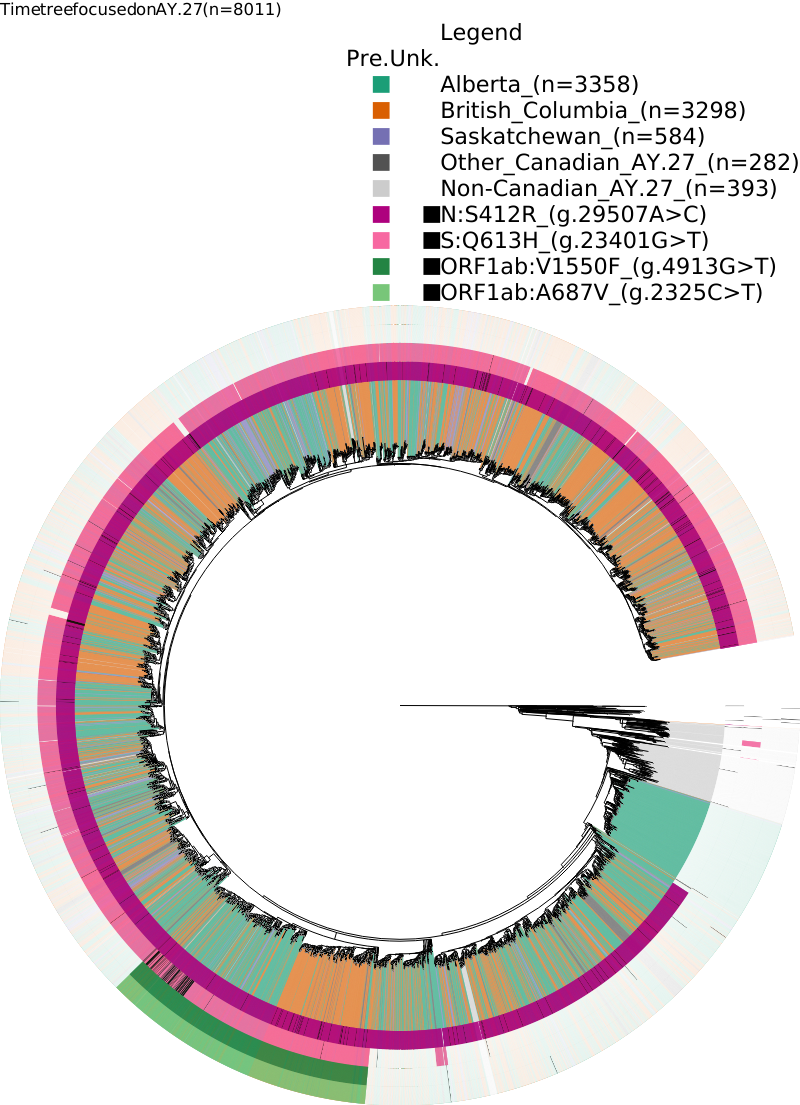

In [28]:
ts = t.tree_styler(mode='c', highlight_style=location_hstyle,
                   annotate_box_width=3000, annotate_box_height=40,
                   legend_nsize=2700, legend_fsize=2700,
                   show_leaf_names=False, annotate_guiding_lines=False,
                   annotate_opacity_absent=1.0, annotate_margin=0, annotate_border_color=None,
                   legend_type_label_present='Pre.', legend_type_label_unknown='Unk.',
                   annotate_border_width=None,
                   legend_title='Legend', annotate_show_box_label=False,
                   title=f'Time tree focused on AY.27 (n={len(t)})',
                   title_fsize=2000,
                   include_unknown=True, annotate_color_unknown='black',
                   tree_scale=17500000)

for province in provinces_list:
    ts = ts.highlight(t_provinces[province], legend_label=f'{province}_(n={len(t_provinces[province])})')
    
ts = ts.highlight(t27_non_canadian, legend_label=f'Non-Canadian_AY.27_(n={len(t27_non_canadian)})')

for mutation in ay27_mutations_percent_list:
    label = ay27_mutations_percent_dict[mutation]
    color = ay27_mutations_colors[mutation]
    ts = ts.annotate(t.hasa(mutation), legend_label=label, color_present=color)
    
# ts.render(w=2400)
ts.render(w=800)